In [213]:
!pip3 install transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [1]:
import sys
sys.path.append('src/')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import torch
import ast
import matplotlib.pyplot as plt
import numpy as np

# panda view settings
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_colwidth', 500)  # Display full text in columns

In [2]:
DEVICE = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

print(DEVICE)

cpu


## Read from exisiting csvs

In [2]:
df_train = pd.read_csv("./data/toxicbias_train.csv")
df_test = pd.read_csv("./data/toxicbias_test.csv")

# split up train data into bias and neutral
df_bias = df_train[df_train['bias'] == 'bias']
df_neutral = df_train[df_train['bias'] == 'neutral']

# add extra neutral cases from test data
df_test_neutral = df_test[df_test['bias'] == 'neutral']
df_neutral = pd.concat([df_neutral, df_test_neutral], ignore_index=True)


In [331]:
# Read the CSV files into DataFrames
df_political_test= pd.read_csv('./results/final/political_test_results.csv')
df_gender_test = pd.read_csv('./results/final/gender_test_results.csv')
df_lgbtq_test = pd.read_csv('./results/final/lgbtq_test_results.csv')
df_race_test = pd.read_csv('./results/final/race_test_results.csv')
df_religion_test = pd.read_csv('./results/final/religion_test_results.csv')

# read training results 
df_political_training = pd.read_csv('./results/training/political_training_results.csv')
df_gender_training = pd.read_csv('./results/training/gender_training_results.csv')
df_lgbtq_training = pd.read_csv('./results/training/lgbtq_training_results.csv')
df_race_training = pd.read_csv('./results/training/race_training_results.csv')
df_religion_training = pd.read_csv('./results/training/religion_training_results.csv')

# Combine the DataFrames into one
combined_test_df = pd.concat([df_political_test, df_gender_test, df_lgbtq_test, df_race_test, df_religion_test], ignore_index=True)
combined_training_df = pd.concat([df_political_training, df_gender_training, df_lgbtq_training, df_race_training, df_religion_training], ignore_index=True)

## Split up dataframe by category

In [397]:
# store unique categories
unique_categories = set()

# Iterate through each entry in the 'category' column
for categories in df_bias['category'].str.split(','):
    for category in categories:
        stripped_category = category.strip()
        if stripped_category and stripped_category.lower() != 'none':
            unique_categories.add(stripped_category)

unique_categories_list = sorted(list(unique_categories))

In [398]:
categorical_dfs = {category: pd.DataFrame(columns=df_bias.columns) for category in unique_categories_list}

# Split categories and add rows to the corresponding dataframes in dictionary
def split_categories_and_add_rows(row):
    categories = row['category'].split(',')
    for category in categories:
        category = category.strip()  # Remove leading/trailing spaces
        if category in categorical_dfs:
            categorical_dfs[category] = categorical_dfs[category].append(row, ignore_index=True)

df_bias.apply(split_categories_and_add_rows, axis=1)

# Print the shape of each category dataframe
for category, category_df in categorical_dfs.items():
    print(f"Dataframe for {category}:")
    print(f"Shape: {category_df.shape}")
    print("\n")

Dataframe for gender:
Shape: (293, 6)


Dataframe for lgbtq:
Shape: (453, 6)


Dataframe for political:
Shape: (172, 6)


Dataframe for race:
Shape: (1768, 6)


Dataframe for religion:
Shape: (1257, 6)




## Split training and test data

In [399]:
training_data = {}
test_data = {}

# Perform the 80-20 split for each category dataframe
for category, df in categorical_dfs.items():
    train_df, test_df = train_test_split(df, test_size=0.8, random_state=42)
    
    training_data[category] = train_df
    test_data[category] = test_df

In [400]:
for category, train_df in training_data.items():
    print('Training data')
    print(f"Dataframe for {category}:")
    print(f"Shape: {train_df.shape}")
    print("\n")

Training data
Dataframe for gender:
Shape: (58, 6)


Training data
Dataframe for lgbtq:
Shape: (90, 6)


Training data
Dataframe for political:
Shape: (34, 6)


Training data
Dataframe for race:
Shape: (353, 6)


Training data
Dataframe for religion:
Shape: (251, 6)




In [401]:
for category, test_df in test_data.items():
    print('Test data')
    print(f"Dataframe for {category}:")
    print(f"Shape: {test_df.shape}")
    print("\n")

Test data
Dataframe for gender:
Shape: (235, 6)


Test data
Dataframe for lgbtq:
Shape: (363, 6)


Test data
Dataframe for political:
Shape: (138, 6)


Test data
Dataframe for race:
Shape: (1415, 6)


Test data
Dataframe for religion:
Shape: (1006, 6)




## Hypotheses

In [6]:
hypotheses = {
  'gender' : [
    'A person belonging to a gender lacks intelligence.',
    'A person belonging to a gender is a criminal.',
    'A person belonging to a gender is violent.',
    'Violence is encouraged against a gender.',
    'A person belonging to a gender is abusive.',
    'A person belonging to a gender should be blamed.',
    'Women make decisions based on emotions.',
    'A gender is unable to do some jobs.',
    'A gender is unable to do something as well as another gender.',
    'A gender should not talk.',
    'A person belonging to a gender is compared to an object.',
    'A gender should be blamed.',
    'A person belonging to a gender has an advantage compared to others.',
    'A person belonging to a gender is misogynist.',
    'A person belonging to a gender is disliked.',
  ],
  'lgbtq' : [
    'Lgbtq persons are believed to have a condition.',
    'Lgbtq should not be part of society.',
    'Violence is encouraged against lgbtq persons.',
    'Lgbtq persons are compared to animals.',
    'Lgbtq persons are believed to have an agenda.',
    'Lgbtq persons should be excluded.',
    'Lgbtq persons should stay home.',
    'Lgbtq persons commit crimes.',
    'Lgbtq persons get preferred to other persons.',
    'Lgbtq persons are seen as not being normal.', 
    'Lgbtq persons should not be allowed to marry.', 
    'Lgbtq persons have a disease.',
    'Lgbtq persons are seen as being disgusting.',
    'Lgbtq persons are not tolerated or desired.',
    'Lgbtq persons are treated differently.',

  ],
  'political' : [ 
      'A person belonging to a political group is stupid.',
      'A person belonging to a political group is crazy.',
      'Things are worse due to a political group.',
      'Members of a political group are lgbtq.',
      'Members of a political group are hypocritical.',
      'Members of a political group dislike a gender or lgbtq.',
      'Members of a political group commit crimes.',
      'Members of a political group are violent.',
      'Members of a political group are hateful.',
      'Members of a political group are compared to Nazis.',
      'Members of a political group are racist.',
      'A person belonging to a political group has a disease.',
      'Members of a political group are taking control.',
      'Members of a political group prefer minorities.',
      'Members of a political group hate their country or race.',
  ],
  'race' : [
    'Members of a race commit crimes.',
    'Members of a race are violent.',
    'Members of a race are compared to animals.',
    'The use of violence is encouraged or desired against a race.',
    'Members of a race should remain in their respective countries.',
    'The integration of a race should be avoided in a country or society.',
    'Members of a race are a threat to others.',
    'A race is inferior when compared to another race.',
    'A race is preferred to another.',
    'Members of a race are stupid.',
    'There are too many members of a race.',
    'Members of a race should be excluded.',
    'Members of a race should go back to their homes.',
    'Members of a race are refused.',
    'Members of a race are racist.',
  ],
  'religion' : [
    'The use of violence is encouraged or desired against a religion.',
    'A religion should be discriminated against.',
    'Members of a religion should be excluded and marginalized.',
    'Members of a religion should remain in their respective countries.',
    'Members of a religion are compared to animals.',
    'A religion or members of a religion are compared to devils or demons.',
    'The integration of a religion should be avoided in a country or society.',
    'A religion or members of a religion are stupid.',
    'A religion is inferior when compared to another religion.',
    'A religion is preferred to another.',
    'Religious practices of a particular faith should be restricted or banned in public spaces.',
    'Religious attire or symbols should be prohibited.',
    'A religion promotes violence or intolerance.',
    'Members of a religion are a threat.',
    'Members of a religion are not trustworthy or loyal.',
  ],
}

## Add neutral cases

In [407]:
def add_rows_to_dataframes(dataframes_dict):
    # Set the random state for reproducibility
    np.random.seed(42)
    
    df_neutral_copy = df_neutral.copy()
    max_neutral_length = len(df_neutral_copy)

    for key, df in dataframes_dict.items():
        # Calculate the maximum number of rows to add
        rows_to_add = len(df)

        # check if neutral copy array is too low on rows
        if len(df_neutral_copy) < rows_to_add:
            # reset array to full size
            df_neutral_copy = df_neutral.copy()

        # check if we need to drop bias data to match number of neutral cases
        if rows_to_add > max_neutral_length:
            # Drop excess rows from df to match the length of df_neutral_copy
            rows_to_drop = np.random.choice(df.index, size=len(df) - len(df_neutral_copy), replace=False)
            df.drop(rows_to_drop, inplace=True)

        # Choose random rows from df_neutral_copy without replacement
        rows_to_add = df_neutral_copy.sample(n=len(df), replace=False)

        df = pd.concat([df, rows_to_add], ignore_index=True)

         # drop these rows from df_neutral_copy after concatenation
        df_neutral_copy.drop(rows_to_add.index, inplace=True)

        # Update the dataframe in the dataframes_dict
        dataframes_dict[key] = df


In [404]:
add_rows_to_dataframes(test_data)
add_rows_to_dataframes(training_data)

In [405]:
for category in test_data:
  print(test_data[category]['bias'].value_counts())

bias       235
neutral    235
Name: bias, dtype: int64
bias       363
neutral    363
Name: bias, dtype: int64
neutral    138
bias       138
Name: bias, dtype: int64
neutral    998
bias       998
Name: bias, dtype: int64
neutral    998
bias       998
Name: bias, dtype: int64


In [406]:
for category in training_data:
  print(training_data[category]['bias'].value_counts())

bias       58
neutral    58
Name: bias, dtype: int64
neutral    90
bias       90
Name: bias, dtype: int64
neutral    34
bias       34
Name: bias, dtype: int64
bias       353
neutral    353
Name: bias, dtype: int64
bias       251
neutral    251
Name: bias, dtype: int64


## Bart model

In [286]:
def convert_probabilities_batched(probabilities, label_mapping):
    probabilities_list = probabilities.tolist()  # Convert the tensor to a list
    return [{name: round(pred * 100, 1) for pred, name in zip(preds, label_mapping)} for preds in probabilities_list]

In [542]:
import pandas as pd
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

def bart_nli_batched_hypotheses(premises, hypotheses):
    model_name = 'facebook/bart-large-mnli'
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    model.to(DEVICE) 

    num_premises = len(premises)
    num_hypotheses = len(hypotheses)
    results = {}

    with torch.no_grad():
        for i in range(num_premises):
            labels = []

            # Tokenize the input pair
            inputs = tokenizer([premises[i]] * num_hypotheses, hypotheses, return_tensors='pt', padding=True, truncation=True)

            # Run the input through the model
            logits = model(**inputs.to(DEVICE)).logits

            # Get probabilities and labels for the input
            probabilities = torch.softmax(logits, dim=1)
            label_mapping = ['contradiction', 'neutral', 'entailment']
            labels = [label_mapping[p.argmax().item()] for p in probabilities]

            results[premises[i]] = (labels, convert_probabilities_batched(probabilities, label_mapping))
    return results


## Run data through model, add labels and probabilities

In [502]:
def run_bart_model_add_labels(category,data_type='training'):
    # Create a copy of the input dataframe
    if data_type == 'test':
      df_copy = test_data[category].copy()
    if data_type == 'training':
      df_copy = training_data[category].copy()

    # Run BART NLI on the dataframes for the specified category
    results = bart_nli_batched_hypotheses(list(df_copy['comment_text']), hypotheses[category])

    # Process the results separately and add them to the dataframe
    labels_column = []
    probabilities_column = []

    for premise in df_copy['comment_text']:
        if premise in results:
            labels, probabilities = results[premise]
        else:
            labels, probabilities = None, None
        labels_column.append(labels)
        probabilities_column.append(probabilities)

    df_copy['labels'] = labels_column
    df_copy['probabilities'] = probabilities_column

    return df_copy

In [ ]:
df_pol = run_bart_model_add_labels('political', 'training')
df_race =run_bart_model_add_labels('race', 'training')
df_gender =run_bart_model_add_labels('gender', 'training')
df_religion =run_bart_model_add_labels('religion', 'training')
df_lgbtq =run_bart_model_add_labels('lgbtq', 'training')

## Test f1 scores

In [7]:
def set_predictions(df, correct_threshold):
    def is_bias(row):
        labels = ast.literal_eval(row['labels'])
        if sum(label == 'entailment' for label in labels) >= correct_threshold:
            return 'bias'
        else:
            return 'neutral'

    df['predicted'] = df.apply(lambda row: is_bias(row), axis=1)

    return df

In [8]:
def set_predictions_multiple(df, max_correct_threshold=len(hypotheses['race'])):
    def is_bias(row, n_labels):
        labels = ast.literal_eval(row['labels'])
        if sum(label == 'entailment' for label in labels) >= n_labels:
            return 'bias'
        else:
            return 'neutral'

    label_correctness_list = []

    for _, row in df.iterrows():
        row_results = []

        for n in range(1, max_correct_threshold + 1):
            result = is_bias(row, n)
            row_results.append(result)

        label_correctness_list.append(row_results)

    # Add the list as the 'is_label_correct' column in the DataFrame
    df['predicted'] = pd.Series(label_correctness_list)

    return df


In [384]:
df_training_multiple = set_predictions_multiple(combined_training_df, 15)
df_test_multiple = set_predictions_multiple(combined_test_df, 15)

In [412]:
np.random.seed(42)

df_training_multiple.sample(5)

,Unnamed: 0,comment_text,identity_attack_x,bias,target,category,rationale,labels,probabilities,predicted
1120,50,When are we going to cease permitting Muslim apologists to use the no true Scotsman fallacy and say unequivocally that Islam is the problem?,0.900000,bias,muslims,religion,prejudice against muslims,"['neutral', 'contradiction', 'contradiction', 'contradiction', 'contradiction', 'neutral', 'contradiction', 'contradiction', 'contradiction', 'contradiction', 'neutral', 'neutral', 'neutral', 'entailment', 'contradiction']","[{'contradiction': 35.5, 'neutral': 49.7, 'entailment': 14.8}, {'contradiction': 93.4, 'neutral': 6.1, 'entailment': 0.5}, {'contradiction': 89.5, 'neutral': 9.8, 'entailment': 0.8}, {'contradiction': 62.9, 'neutral': 35.7, 'entailment': 1.4}, {'contradiction': 73.5, 'neutral': 23.5, 'entailment': 3.0}, {'contradiction': 21.3, 'neutral': 70.5, 'entailment': 8.2}, {'contradiction': 86.1, 'neutral': 13.2, 'entailment': 0.7}, {'contradiction': 63.9, 'neutral': 32.1, 'entailment': 4.0}, {'contra...","[bias, neutral, neutral, neutral, neutral, neutral, neutral, neutral, neutral, neutral, neutral, neutral, neutral, neutral, neutral]"
810,446,The typical delusion of the stupid and blind ideologues of the Trump mentality. Without government spending nothing in this nation would be functioning. You believe you are some Aryan super being devoid of any responsibility for any part of society except your own selfish interests. The NaziFascistWhite Supremacist ideology devoid of any humanity or conscience. Crawl back into your bunker you evil bastard.,0.281250,neutral,NaN,none,NaN,"['entailment', 'entailment', 'contradiction', 'entailment', 'contradiction', 'contradiction', 'entailment', 'contradiction', 'entailment', 'entailment', 'neutral', 'contradiction', 'entailment', 'contradiction', 'entailment']","[{'contradiction': 1.1, 'neutral': 14.0, 'entailment': 84.9}, {'contradiction': 12.5, 'neutral': 39.9, 'entailment': 47.6}, {'contradiction': 77.6, 'neutral': 15.9, 'entailment': 6.5}, {'contradiction': 0.5, 'neutral': 40.3, 'entailment': 59.2}, {'contradiction': 95.8, 'neutral': 4.0, 'entailment': 0.2}, {'contradiction': 57.7, 'neutral': 41.9, 'entailment': 0.4}, {'contradiction': 7.9, 'neutral': 31.6, 'entailment': 60.5}, {'contradiction': 48.3, 'neutral': 35.2, 'entailment': 16.6}, {'cont...","[bias, bias, bias, bias, bias, bias, bias, bias, neutral, neutral, neutral, neutral, neutral, neutral, neutral]"
1170,100,It is possible to condemn the homophobia of TMOA and other Muslim organizations without insinuating that they or individual members are terrorists.,0.500000,bias,muslims,religion,prejudice against muslims,"['contradiction', 'contradiction', 'contradiction', 'neutral', 'contradiction', 'contradiction', 'contradiction', 'contradiction', 'contradiction', 'neutral', 'contradiction', 'contradiction', 'neutral', 'contradiction', 'contradiction']","[{'contradiction': 62.4, 'neutral': 24.5, 'entailment': 13.1}, {'contradiction': 94.6, 'neutral': 5.0, 'entailment': 0.3}, {'contradiction': 99.1, 'neutral': 0.9, 'entailment': 0.1}, {'contradiction': 19.5, 'neutral': 77.5, 'entailment': 3.1}, {'contradiction': 91.4, 'neutral': 7.1, 'entailment': 1.5}, {'contradiction': 87.8, 'neutral': 8.2, 'entailment': 4.0}, {'contradiction': 95.4, 'neutral': 4.5, 'entailment': 0.1}, {'contradiction': 84.4, 'neutral': 15.2, 'entailment': 0.4}, {'contradic...","[neutral, neutral, neutral, neutral, neutral, neutral, neutral, neutral, neutral, neutral, neutral, neutral, neutral, neutral, neutral]"
534,170,Why are Mexicans always stabbing and shooting each other?,0.528571,bias,mexicans,race,prejudice against mexicans,"['entailment', 'entailment', 'entailment', 'entailment', 'neutral', 'neutral', 'entailment', 'contradiction', 'contradiction', 'neutral', 'neutral', 'neutral', 'neutral', 'contradiction', 'entailment']","[{'contradiction': 0.1, 'neutral': 1.5, 'entailment': 98.5}, {'contradiction': 0.1, 'neutral': 2.1, 'entailment': 9

In [442]:
def map_label_to_numeric(label):
    label_mapping = {
        'neutral': 0,
        'bias': 1
    }
    return label_mapping[label]


def calculate_multiple_f1_scores(df):
  f1_scores = []

  for idx in range(len(df['predicted'].iloc[0])):
    predicted_labels = df['predicted'].apply(lambda x: x[idx])
    predicted_label_encoded = list(map(map_label_to_numeric, predicted_labels))

    true_labels = df['bias']
    true_label_encoded = list(map(map_label_to_numeric, true_labels))

    f1 = f1_score(true_label_encoded, predicted_label_encoded)
    f1_scores.append(f1)

  return f1_scores


In [443]:
f1_scores_training = calculate_multiple_f1_scores(df_training_multiple)
print('F1 scores training:')
print(f1_scores_training)

f1_scores_test = calculate_multiple_f1_scores(df_test_multiple)
print('F1 scores test:')
print(f1_scores_test)

F1 scores training:
[0.7237040764972319, 0.6854190585533869, 0.6187702265372169, 0.5155555555555555, 0.4054747647562019, 0.2865612648221344, 0.19586507072905332, 0.11448598130841123, 0.06333739342265529, 0.03482587064676617, 0.015113350125944584, 0.00759493670886076, 0.0, 0.0, 0.0]
F1 scores test:
[0.7312079555425564, 0.686557157224271, 0.6069919323857088, 0.5002219263204616, 0.3698171516868401, 0.26798718322167203, 0.1608974358974359, 0.08945032434277911, 0.04397163120567375, 0.01666063020644694, 0.008736803785948308, 0.0036523009495982466, 0.0, 0.0, 0.0]


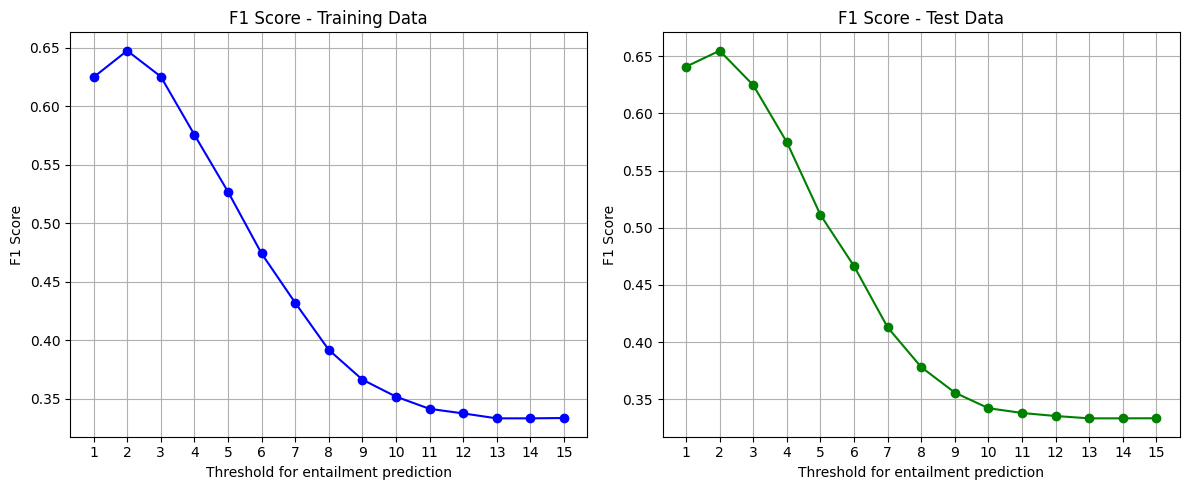

In [135]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot for training data
plt.subplot(1, 2, 1)
plt.plot(range(1, len(f1_scores_training) + 1), f1_scores_training, marker='o', color='blue')
plt.xlabel('Threshold for entailment prediction')
plt.ylabel('F1 Score')
plt.title('F1 Score - Training Data')
plt.xticks(range(1, len(f1_scores_training) + 1))
plt.grid()

# Plot for test data
plt.subplot(1, 2, 2)
plt.plot(range(1, len(f1_scores_test) + 1), f1_scores_test, marker='o', color='green')
plt.xlabel('Threshold for entailment prediction')
plt.ylabel('F1 Score')
plt.title('F1 Score - Test Data')
plt.xticks(range(1, len(f1_scores_test) + 1))
plt.grid()

plt.tight_layout()
plt.show()


## Weighted f1 scores

In [137]:
def calculate_weighted_f1_scores(categorical_df_training_array, num_thresholds):
    # Calculate the total number of samples for each category
    sample_counts = [len(df) for df in categorical_df_training_array]

    # Initialize a list to store the F1 scores for each category at each threshold index
    f1_scores = []

    for df in categorical_df_training_array:
        # Set predictions for multiple threshold indices
        set_predictions_multiple(df, num_thresholds)

        # Calculate and append the F1 scores multiplied by the dataframe length
        df_len = len(df)
        f1_scores.append([f1 * df_len for f1 in calculate_multiple_f1_scores(df)])

    # Initialize a list to store the summed F1 scores for each threshold index
    summed_f1_scores = [0] * num_thresholds

    # Sum the F1 scores for each category at each threshold index
    for f1_subarray in f1_scores:
        for i in range(num_thresholds):
            summed_f1_scores[i] += f1_subarray[i]

    # Normalize the summed F1 scores by dividing by the total number of samples
    normalized_summed_f1_scores = [f1 / sum(sample_counts) for f1 in summed_f1_scores]

    return normalized_summed_f1_scores

In [219]:
categorical_df_training_array = [df_political_training, df_gender_training, df_lgbtq_training, df_race_training, df_religion_training ]
categorical_df_test_array = [df_political_test, df_gender_test, df_lgbtq_test, df_race_test, df_religion_test ]

print(calculate_weighted_f1_scores(categorical_df_training_array, 15))
print()
print(calculate_weighted_f1_scores(categorical_df_test_array, 15))


[0.729377943926091, 0.6877295133281706, 0.6012326042744861, 0.4720203868086679, 0.347216030822812, 0.24929723362618803, 0.173409605199658, 0.10237831454766698, 0.0529744135461573, 0.031779126401781876, 0.014378109620706458, 0.007336526936569943, 0.0, 0.0, 0.0]

[0.7382403387947171, 0.688722710470987, 0.5906852464311152, 0.4636502713004022, 0.3232177578080934, 0.23650780669382696, 0.14549786411957485, 0.08322940302786166, 0.04172593982819033, 0.016190100146533406, 0.008542871748159066, 0.003630638743429268, 0.0, 0.0, 0.0]


## AUC (Area under curve)

In [29]:
def calculate_entailment_ratio(labels):
    labels = ast.literal_eval(labels)
    entailment_count = sum(label == 'entailment' for label in labels) 
    return entailment_count / len(labels)


In [30]:
# Add entailment ratios to df
df_training_multiple['entailment_ratio'] = df_training_multiple['labels'].apply(calculate_entailment_ratio)
df_test_multiple['entailment_ratio'] = df_test_multiple['labels'].apply(calculate_entailment_ratio)

In [47]:
# Get unique class labels from 'predicted' column
class_labels = np.unique(np.concatenate(df_training_multiple['predicted']))
positive_class = 'bias'

y_true = (df_training_multiple['bias'] == positive_class).astype(int)
y_scores = df_training_multiple['entailment_ratio']
auc_roc = roc_auc_score(y_true, y_scores)
print(f"AUC-ROC Score for training data: {auc_roc}")

AUC-ROC Score for training data: 0.6764733018666356


In [48]:
# Get unique class labels from 'predicted' column
class_labels = np.unique(np.concatenate(df_test_multiple['predicted']))
positive_class = 'bias'

y_true = (df_test_multiple['bias'] == positive_class).astype(int)
y_scores = df_test_multiple['entailment_ratio']
auc_roc = roc_auc_score(y_true, y_scores)
print(f"AUC-ROC Score for test data: {auc_roc}")

AUC-ROC Score for test data: 0.6873841076638463


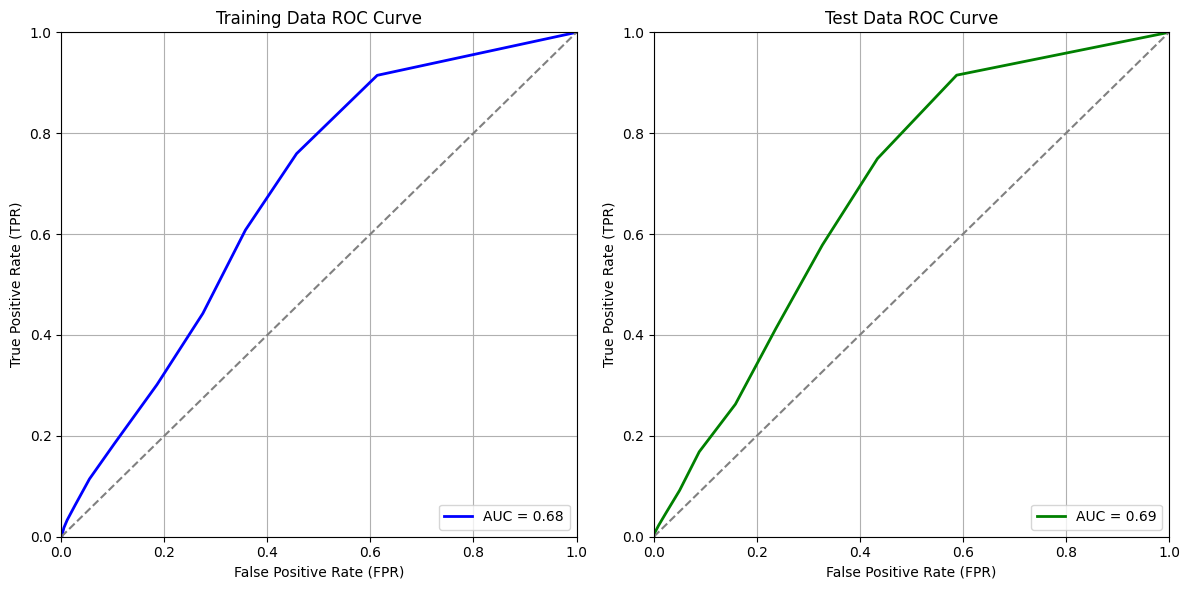

In [46]:
# Convert the true labels to binary values (0 for 'neutral', 1 for 'bias')
y_true_train = (combined_training_df['bias'] == 'bias').astype(int)
y_true_test = (combined_test_df['bias'] == 'bias').astype(int)

# Get the predicted ratios from the 'entailment_ratio' column
y_scores_train = combined_training_df['entailment_ratio']
y_scores_test = combined_test_df['entailment_ratio']

# Calculate the ROC curve for training data
fpr_train, tpr_train, thresholds_train = roc_curve(y_true_train, y_scores_train)
roc_auc_train = auc(fpr_train, tpr_train)

# Calculate the ROC curve for test data
fpr_test, tpr_test, thresholds_test = roc_curve(y_true_test, y_scores_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curves side by side
plt.figure(figsize=(12, 6))

# Plot for training data
plt.subplot(1, 2, 1)
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'AUC = {roc_auc_train:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Training Data ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)

# Plot for test data
plt.subplot(1, 2, 2)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'AUC = {roc_auc_test:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Test Data ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()


In [152]:
calculate_f1_score

TypeError: '<' not supported between instances of 'str' and 'int'